In this tutorial, we will explore the mechanisms of attention across various contexts, both in isolation and in combination with other architectural elements, to discover the most effective ways to utilize them. Attention mechanisms have revolutionized the field of machine learning, offering a nuanced approach to handling sequence data and enhancing model interpretability. By integrating these mechanisms with different architectures, we can enhance their capacity to focus on relevant features within large datasets. This exploration will not only deepen our understanding of attention but also guide us in leveraging its potential to improve model performance across diverse applications.

# EX1 : architecture hybride, Transformreur et CNN

In this hybrid architecture, we utilize two complementary approaches:

The CNN (Convolutional Neural Network) acts as a local feature extractor. Through convolutional layers and pooling operations, the network captures spatial patterns (shapes, textures, etc.) present in images. The Transformer then processes the extracted features as a sequence using Multi-Head Attention blocks and feed-forward networks. By "looking" at all the feature vectors, the Transformer exploits global dependencies within the image. After converting the convolutional outputs into a sequence, a Global Average Pooling operation aggregates information across the entire sequence, and a MLP (Multi-Layer Perceptron) finalizes the class prediction (here, 10 classes for CIFAR-10).

# Q1
Use the Keras API to download the CIFAR-10 dataset. Then, convert the images to float32 type and normalize them so that the pixel values are between 0 and 1. Tip: To normalize, divide the pixel values by 255.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


# Chargement des données CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)



---



---



---



# Q2
Review the hyperparameters below and explain in detail the role and impact of each on the architecture and functioning of the model:

In [2]:
# Paramètres Hyper
num_classes = 10
input_shape = (32, 32, 3)
num_heads = 2
embed_dim = 128  # Dimension d'embedding pour le Transformer
ff_dim = 256     # Taille du réseau feed-forward dans le Transformer
num_transformer_blocks = 2
mlp_units = [128, 64]
mlp_dropout = 0.2
dropout = 0.1

**Response and Explanation:**

**num_classes = 10**

*Role:* This parameter defines the number of output classes for the model.  
*Impact:* For CIFAR-10, which includes 10 categories of images, the final layer of the model will use 10 neurons with softmax activation to produce a probability distribution across these 10 classes.

**input_shape = (32, 32, 3)**

*Role:* Specifies the shape of the input images to the model.  
*Impact:* Here, each image is 32x32 pixels with 3 channels (R, G, B). This allows the first layer of the model to know the expected dimension of the input data.

**num_heads = 2**

*Role:* Defines the number of attention heads in the Multi-Head Attention layer used in Transformer blocks.  
*Impact:* With 2 heads, the model can simultaneously focus on two different aspects or subspaces of the sequence representations, enhancing its ability to model complex relationships between different parts of the input.

**embed_dim = 128**

*Role:* Corresponds to the dimension of embedding, i.e., the size of the feature vector representing each token (or patch) in the Transformer.  
*Impact:* An embed_dim of 128 allows for capturing a reasonable amount of information for each token. Too small a dimension might lose information, whereas too large a dimension would increase the number of parameters and the complexity of the model.

**ff_dim = 256**

*Role:* Specifies the size (number of neurons) of the hidden layer in the feed-forward network (FFN) inside each Transformer block.  
*Impact:* A feed-forward network of size 256 provides sufficient capacity to model complex nonlinear relationships after the attention operation. However, increasing this size implies more parameters and a higher risk of overfitting if not properly managed with data amount or regularization.




---



---



---



---



**Q3**

Use the Keras functional API to construct an image classification model for the CIFAR-10 dataset. The model should follow the architecture below:

***Input:***

---

Dimensions: (32, 32, 3)

**CNN Part (Feature Extraction):**

**a. First convolutional layer:**

- Type: Conv2D
- Filters: 32
- Filter size: (3, 3)
- Activation: relu
- Padding: same

**b. First pooling layer:**

- Type: MaxPooling2D
- Size: (2, 2)

**c. Second convolutional layer:**

- Type: Conv2D
- Filters: 64
- Filter size: (3, 3)
- Activation: relu
- Padding: same

**d. Second pooling layer:**

- Type: MaxPooling2D
- Size: (2, 2)

**e. Third convolutional layer:**

- Type: Conv2D
- Filters: 128
- Filter size: (3, 3)
- Activation: relu
- Padding: same  
  *Note:* Do not apply pooling after this layer to retain sufficient spatial dimensions.

***Transformation into sequence for the Transformer:***

---

Use a Reshape layer to transform the CNN output into a sequence.  
*Hint:* If the CNN output has the shape (8, 8, 128), the transformation should yield a tensor of shape (64, 128).

**Transformer Part (Attention):**

---

Apply 2 Transformer blocks.  
Each Transformer block should include the following operations:

**a. Multi-Head Attention:**

- Number of heads: 2
- Key dimension (key_dim): 128
- Use the same input for query, key, and value (self-attention).

**b. Dropout and Normalization:**

- Apply Dropout to the attention output.
- Add a residual connection (addition of input and attention output).
- Apply a LayerNormalization layer.

**c. Feed-Forward Network:**

- First dense layer: 256 units with relu activation.
- Second dense layer: 128 units (to restore the embedding dimension).
- Apply Dropout to the feed-forward network output.
- Add another residual connection followed by LayerNormalization.

***Aggregation and Classification:***

---

**a. Global Average Pooling:**

Apply GlobalAveragePooling1D to aggregate the sequence into a single vector.

**b. MLP (Multi-Layer Perceptron):**

- Add a Dense layer with 128 units and relu activation, followed by Dropout (e.g., rate 0.2).
- Add a second Dense layer with 64 units and relu activation, followed by Dropout (rate 0.2).

**c. Output Layer:**

Add a Dense layer with 10 units (for CIFAR-10) and softmax activation.


In [3]:
# Multi-Head Attention block
def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout_rate):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    attn_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)  # Residual connection

    # Feed-forward network
    ffn = layers.Dense(ff_dim, activation="relu")(attn_output)
    ffn = layers.Dense(embed_dim)(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(attn_output + ffn)  # Second residual connection

# Functional API for proper architecture
inputs = layers.Input(shape=input_shape)

# Convolutional Feature Extractor
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(embed_dim, (3, 3), activation='relu', padding='same')(x)
# *** Removed third MaxPooling2D to preserve (8, 8) spatial dimensions ***

# Reshape into sequence format for Transformer
x = layers.Reshape((8 * 8, embed_dim))(x)  # Now matches expected shape

# Transformer Blocks
for _ in range(num_transformer_blocks):
    x = transformer_block(x, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout)

# Global Average Pooling
x = layers.GlobalAveragePooling1D()(x)

# MLP Head
for units in mlp_units:
    x = layers.Dense(units, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

# Output Layer
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Model Definition
model = Model(inputs, outputs)


# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 128)   │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 128)   │    131,968 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128)   │          0 │ reshape[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 128)   │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 128)   │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0] 

 Total params: 515,466 (1.97 MB)

 Trainable params: 515,466 (1.97 MB)

 Non-trainable params: 0 (0.00 B)



---



---



---



# Q4
Use "plot model" from Keras to present the model structure

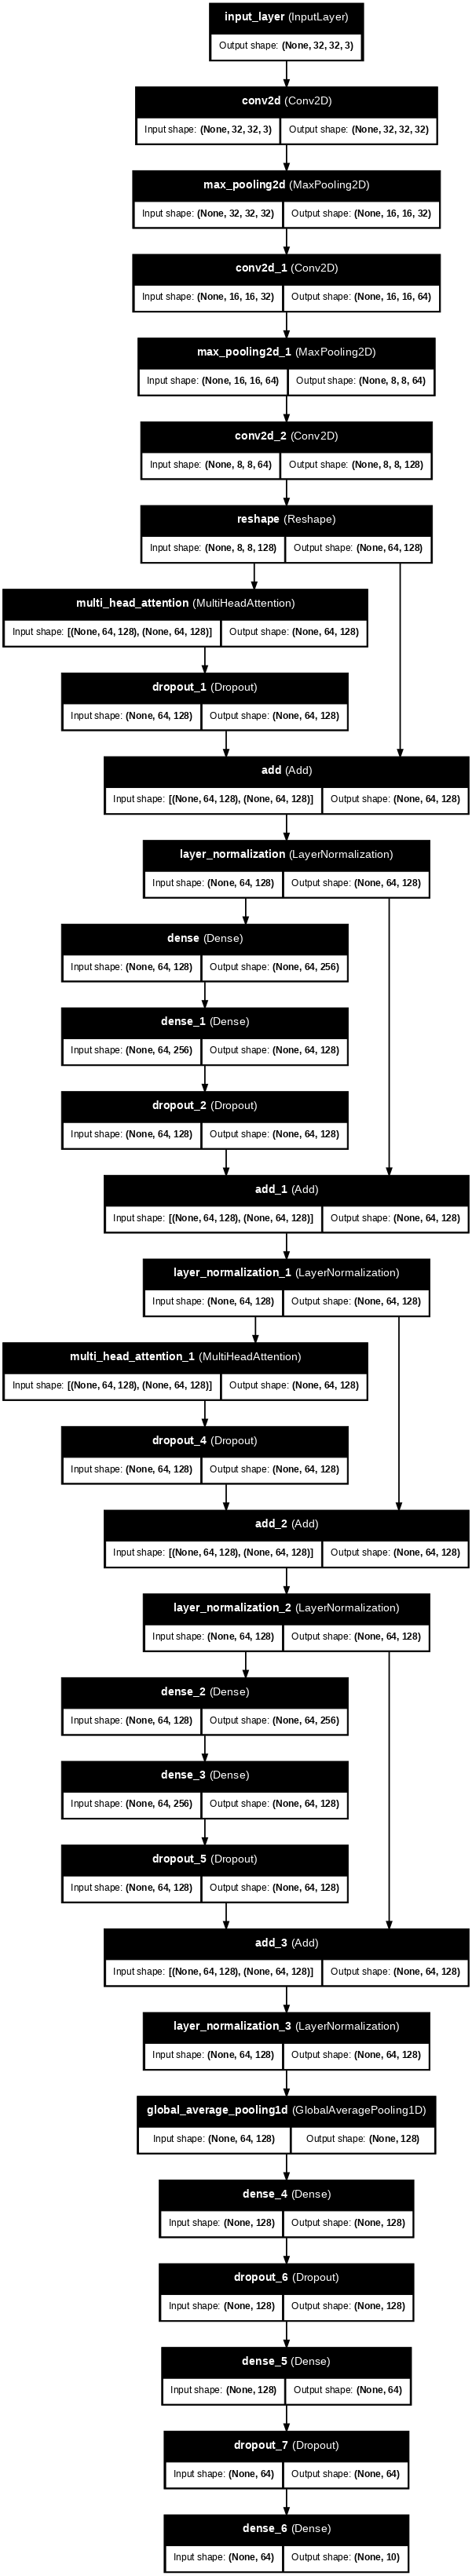

In [7]:
!pip install pydot
from tensorflow.keras.utils import plot_model

# --- Visualisation de la structure du modèle ---
plot_model(model,
           to_file='/content/model_structure.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',
           dpi=64)
#you can dowload the plot:
#from IPython.display import Image
#Image('/content/model_structure.png')

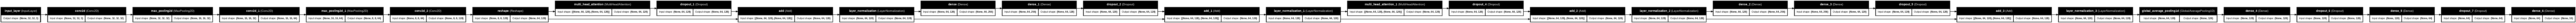



---



---



---



# Q5
Describe this structure et explain input et output shapes and the number of parameters at each step

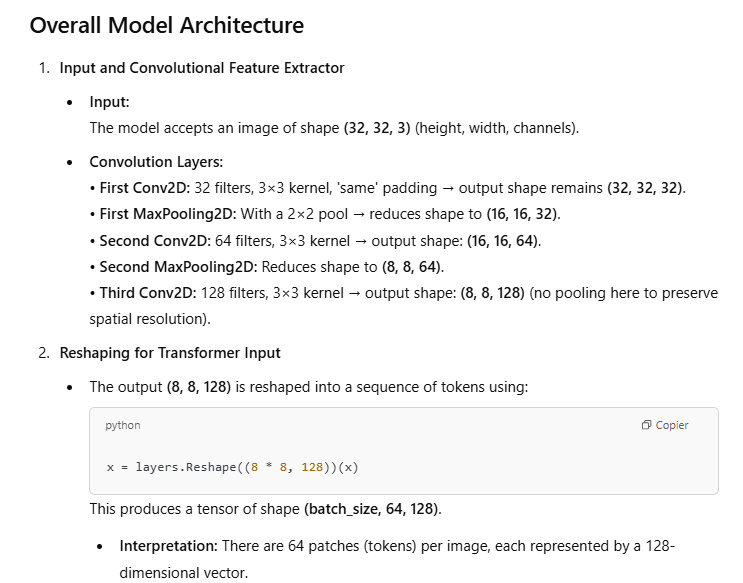

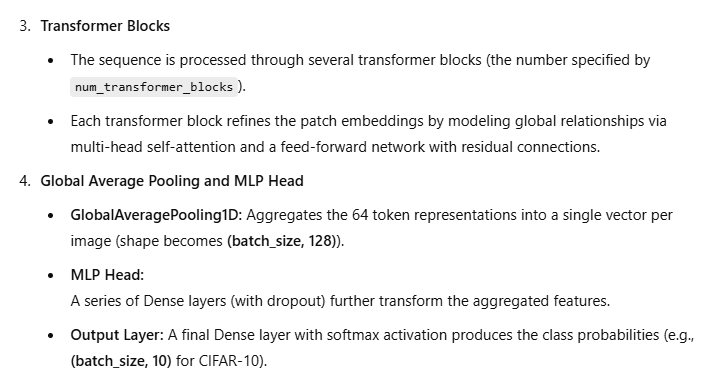



---



---



**Detailed Study of the Transformer Block**

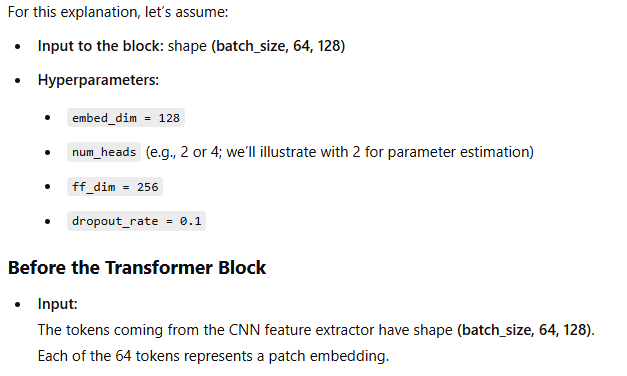



**Inside the Transformer Block**
1. Multi-Head Self-Attention
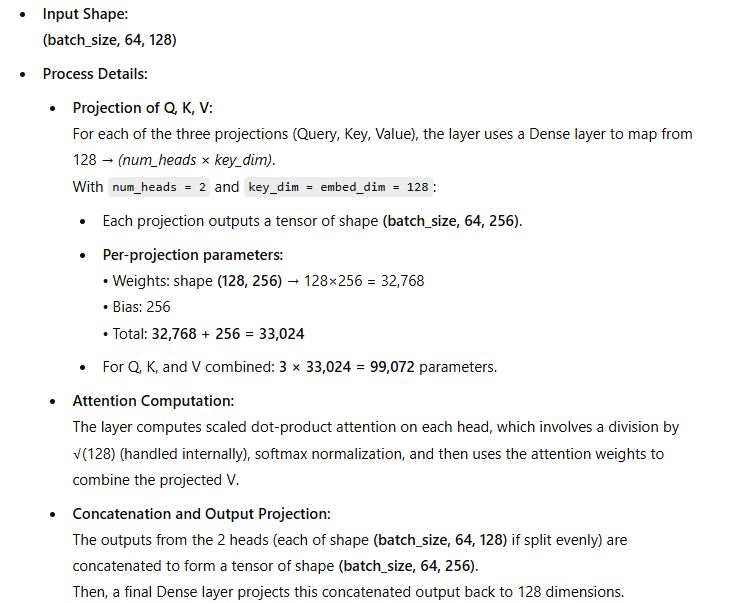
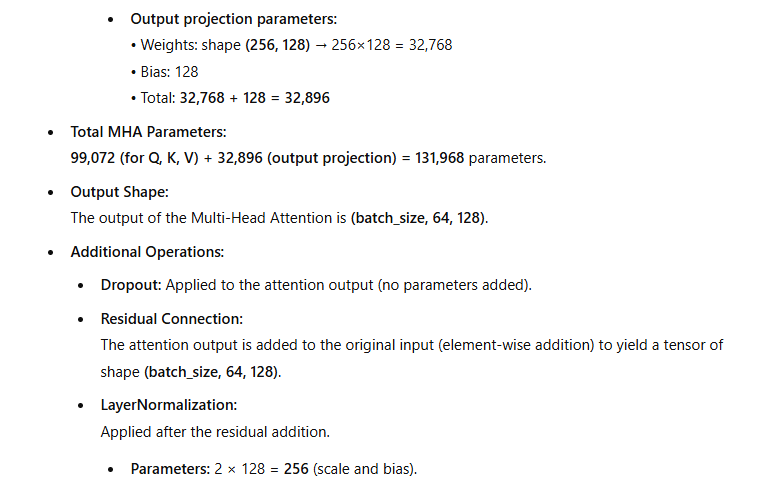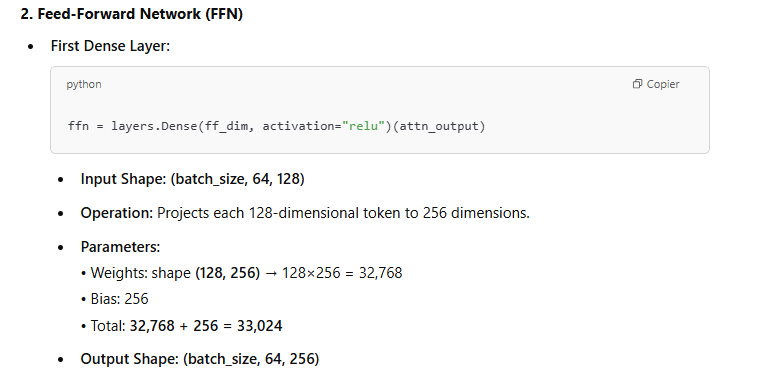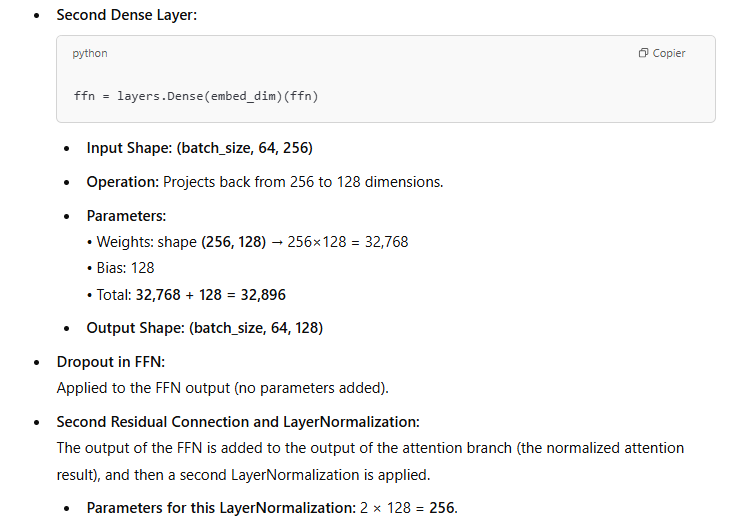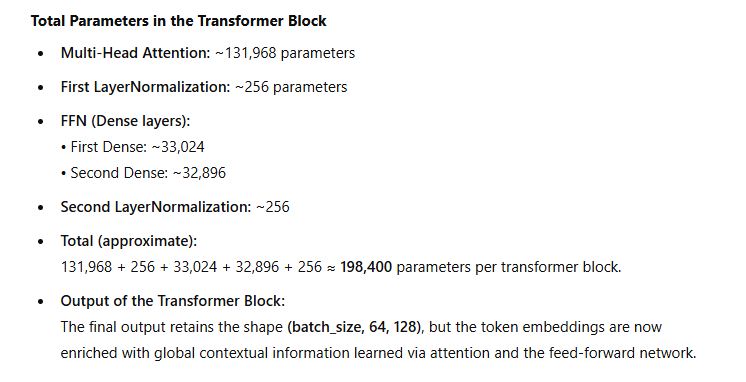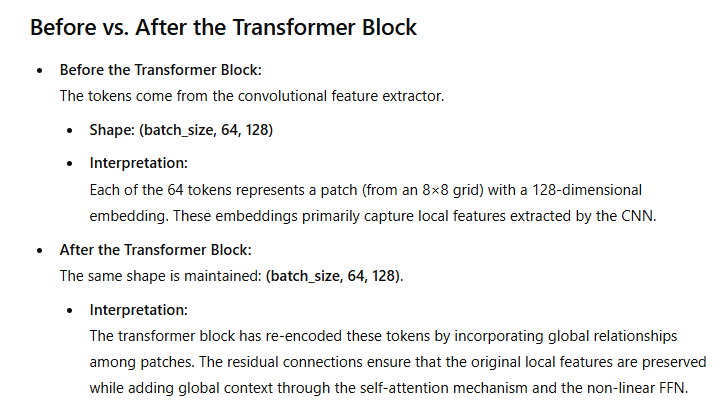

                           Input
                (batch, seq_length, 128)
                             │
                             ▼
                ┌─────────────────────────┐
                │  Dense Projection (Q)   │
                │  128  →  256            │
                └─────────────────────────┘
                             │
                             ▼
                ┌─────────────────────────┐
                │  Dense Projection (K)   │
                │  128  →  256            │
                └─────────────────────────┘
                             │
                             ▼
                ┌─────────────────────────┐
                │  Dense Projection (V)   │
                │  128  →  256            │
                └─────────────────────────┘
                             │
                             ▼
             Q, K, V chacun de forme (batch, seq_length, 256)
                             │
                             ▼
              ┌────────────────────────────────────┐
              │     Split into 2 Heads             │
              │  (Each head: (batch, seq_length, 128)) │
              └────────────────────────────────────┘
                             │
                             ▼
             ┌────────────────────────────────────┐
             │   Scaled Dot-Product Attention     │
             │  (Calculé en parallèle pour 2 têtes) │
             └────────────────────────────────────┘
                             │
                             ▼
            Concatenation des 2 têtes:
                (batch, seq_length, 256)
                             │
                             ▼
                ┌─────────────────────────┐
                │ Final Dense Projection  │
                │      256 → 128          │
                └─────────────────────────┘
                             │
                             ▼
                           Output
                (batch, seq_length, 128)


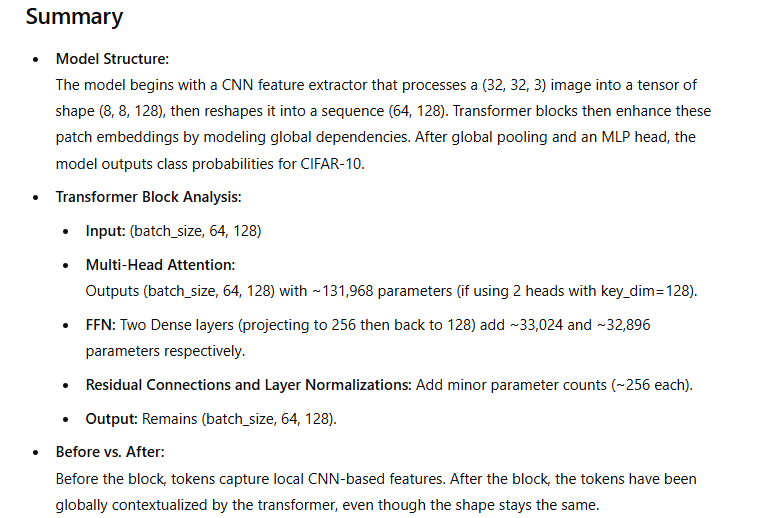



---



---





---



---



---



# Q6
Train the obtained model

In [8]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train Model
model.fit(x_train, y_train, batch_size=464, epochs=50, validation_data=(x_test, y_test))

# Evaluate Model
model.evaluate(x_test, y_test)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - accuracy: 0.1366 - loss: 2.2702 - val_accuracy: 0.2633 - val_loss: 1.9072
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2839 - loss: 1.8557 - val_accuracy: 0.4177 - val_loss: 1.5766
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4182 - loss: 1.5572 - val_accuracy: 0.5075 - val_loss: 1.3350
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4999 - loss: 1.3567 - val_accuracy: 0.5648 - val_loss: 1.1867
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5611 - loss: 1.2215 - val_accuracy: 0.6052 - val_loss: 1.0775
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5942 - loss: 1.1357 - val_accuracy: 0.6291 - val_loss: 1.0150
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6312 - loss: 1.0359 - val_accuracy: 0.6536 - val_loss: 0.9622
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.6739 - loss: 0.9296 - val_

[1.2187734842300415, 0.7405999898910522]



---



---



---



**Q7**

The initial version of your model does not return the attention scores from the MultiHeadAttention layer. Modify the code so that the MultiHeadAttention layer returns both the output and the attention scores. In your solution, include the necessary changes to the transformer block (or the relevant part of the model) that allow you to retrieve these attention scores.

Fllow those points :


Which parameter(s) need to be changed (e.g., using return_attention_scores=True).
How the modification enables you to extract the attention scores.
How you would then adjust the model’s output to include the attention scores along with the classification predictions.

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 16, 16, 32)     │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 8, 8, 64)       │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 64, 128)        │              0 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ [(None, 64, 128),      │        131,968 │ reshape_6[0][0],       │
│ (MultiHeadAttention)      │ (None, 2, 64, 64)]     │                │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 64, 128)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 64, 128)        │              0 │ reshape_6[0][0],       │
│                           │                        │                │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 64, 128)        │            256 │ add_14[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 64, 256)        │         33,024 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 64, 128)        │         32,896 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 64, 128)        │              0 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 64, 128)        │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_35[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 64, 128)        │            256 │ add_15[0][0]           │
│ (LayerNormalization) 

 Total params: 317,066 (1.21 MB)

 Trainable params: 317,066 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - dense_36_categorical_accuracy: 0.1905 - dense_36_loss: 2.0898 - loss: 2.0898 - multi_head_attention_7_dummy_metric: 0.0000e+00 - multi_head_attention_7_loss: 0.0000e+00 - val_dense_36_categorical_accuracy: 0.3557 - val_dense_36_loss: 1.6049 - val_loss: 1.6036 - val_multi_head_attention_7_dummy_metric: 0.0000e+00 - val_multi_head_attention_7_loss: 0.0000e+00
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - dense_36_categorical_accuracy: 0.3800 - dense_36_loss: 1.5810 - loss: 1.5810 - multi_head_attention_7_dummy_metric: 0.0000e+00 - multi_head_attention_7_loss: 0.0000e+00 - val_dense_36_categorical_accuracy: 0.4950 - val_dense_36_loss: 1.3230 - val_loss: 1.3216 - val_multi_head_attention_7_dummy_metric: 0.0000e+00 - val_multi_head_attention_7_loss: 0.0000e+00
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - dense_36_categorical_accuracy: 0.4903 - dense_36_loss: 1.3540 - loss: 1.3540 - multi_head_attention_7_dummy_metric:

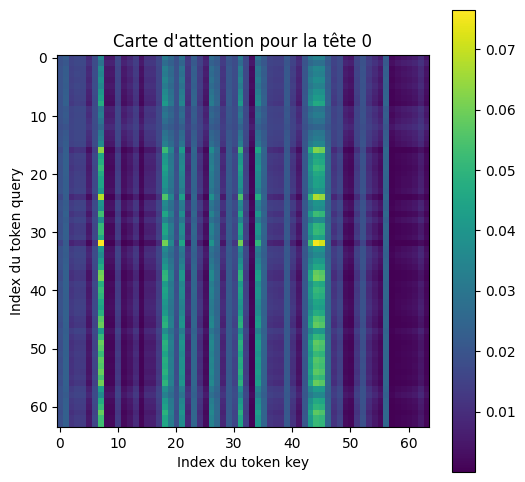

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# ---------------------------
# Hyperparamètres du modèle
# ---------------------------
input_shape = (32, 32, 3)
num_classes = 10
num_heads = 2          # Nombre de têtes d'attention
embed_dim = 128        # Dimension des embeddings (doit correspondre à la sortie du CNN)
ff_dim = 256           # Dimension du réseau feed-forward
dropout_rate = 0.1
mlp_units = [128, 64]
num_transformer_blocks = 1  # Pour l'exemple, on utilise 1 bloc Transformer

# -------------------------------------------------------
# Définition du bloc Transformer avec extraction d'attention
# -------------------------------------------------------
def transformer_block_with_attention(inputs, embed_dim, num_heads, ff_dim, dropout_rate):
    # Multi-Head Attention avec retour des scores d'attention
    attn_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
    attn_output, attn_scores = attn_layer(inputs, inputs, return_attention_scores=True)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    # Première connexion résiduelle suivie de LayerNormalization
    attn_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Réseau Feed-Forward
    ffn = layers.Dense(ff_dim, activation="relu")(attn_output)
    ffn = layers.Dense(embed_dim)(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    # Seconde connexion résiduelle suivie de LayerNormalization
    output = layers.LayerNormalization(epsilon=1e-6)(attn_output + ffn)
    return output, attn_scores

# -------------------------------------
# Définition du modèle complet (ViT hybride)
# -------------------------------------
inputs = layers.Input(shape=input_shape)

# Extracteur de caractéristiques par CNN
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)  # Shape: (16, 16, 32)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)  # Shape: (8, 8, 64)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# On conserve la dimension spatiale : (8, 8, 128)

# Transformation en séquence pour le Transformer
x = layers.Reshape((8 * 8, 128))(x)  # Shape: (batch_size, 64, 128)

# Bloc Transformer qui renvoie également les scores d'attention
x, attn_scores = transformer_block_with_attention(x, embed_dim=embed_dim,
                                                    num_heads=num_heads, ff_dim=ff_dim,
                                                    dropout_rate=dropout_rate)

# Global Average Pooling pour agréger la séquence
x = layers.GlobalAveragePooling1D()(x)  # Shape: (batch_size, 128)

# Tête MLP pour la classification
for units in mlp_units:
    x = layers.Dense(units, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Le modèle renvoie deux sorties : la prédiction et les scores d'attention
model = Model(inputs, [outputs, attn_scores])
model.summary()

# ---------------------------------------------------
# Définition d'une fonction de perte et d'une métrique dummy pour l'attention
# ---------------------------------------------------
def dummy_loss(y_true, y_pred):
    return tf.zeros_like(y_pred)

def dummy_metric(y_true, y_pred):
    return tf.constant(0.0)

# Compilation du modèle avec deux sorties
# On utilise une perte classique pour la classification et une dummy loss pour les scores d'attention.
model.compile(optimizer='adam',
              loss=['categorical_crossentropy', dummy_loss],
              loss_weights=[1.0, 0.0],
              metrics=[tf.keras.metrics.CategoricalAccuracy(), dummy_metric])

# ---------------------------------------------------
# Chargement et prétraitement des données CIFAR-10
# ---------------------------------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

# Création de labels dummy pour la sortie d'attention
dummy_y_train = tf.zeros_like(y_train)
dummy_y_test  = tf.zeros_like(y_test)

# ---------------------------------------------------
# Entraînement du modèle
# ---------------------------------------------------
history = model.fit(x_train, [y_train, dummy_y_train],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, dummy_y_test]))

score = model.evaluate(x_test, [y_test, dummy_y_test])
print("Test loss:", score[0])
print("Test accuracy:", score[1])



In [37]:
history = model.fit(x_train, [y_train, dummy_y_train],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, dummy_y_test]))

score = model.evaluate(x_test, [y_test, dummy_y_test])
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - dense_36_categorical_accuracy: 0.7433 - dense_36_loss: 0.7361 - loss: 0.7361 - multi_head_attention_7_dummy_metric: 0.0000e+00 - multi_head_attention_7_loss: 0.0000e+00 - val_dense_36_categorical_accuracy: 0.7149 - val_dense_36_loss: 0.8431 - val_loss: 0.8437 - val_multi_head_attention_7_dummy_metric: 0.0000e+00 - val_multi_head_attention_7_loss: 0.0000e+00
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - dense_36_categorical_accuracy: 0.7666 - dense_36_loss: 0.6854 - loss: 0.6854 - multi_head_attention_7_dummy_metric: 0.0000e+00 - multi_head_attention_7_loss: 0.0000e+00 - val_dense_36_categorical_accuracy: 0.7299 - val_dense_36_loss: 0.8107 - val_loss: 0.8114 - val_multi_head_attention_7_dummy_metric: 0.0000e+00 - val_multi_head_attention_7_loss: 0.0000e+00
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - dense_36_categorical_accuracy: 0.7732 - dense_36_loss: 0.6623 - loss: 0.6623 - multi_head_attention_7_dummy_metric: 



---



---



---



**Q8**

Plot and Interpret Attention Maps for Multiple Images :

Since the image is divided into 64 patches (from an 8×8 grid), the attention map is initially 64×64.
By reshaping the 64×64 attention map into a shape of 8×8×8×8, you group tokens by their original spatial arrangement.
Averaging over the first two dimensions (i.e., averaging over patches in the same row and column) gives you an 8×8 map that reflects the average attention between different regions of the image.
The final plot should display the original images along with their attention maps side by side, allowing you to visually compare the model’s focus areas across multiple examples.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


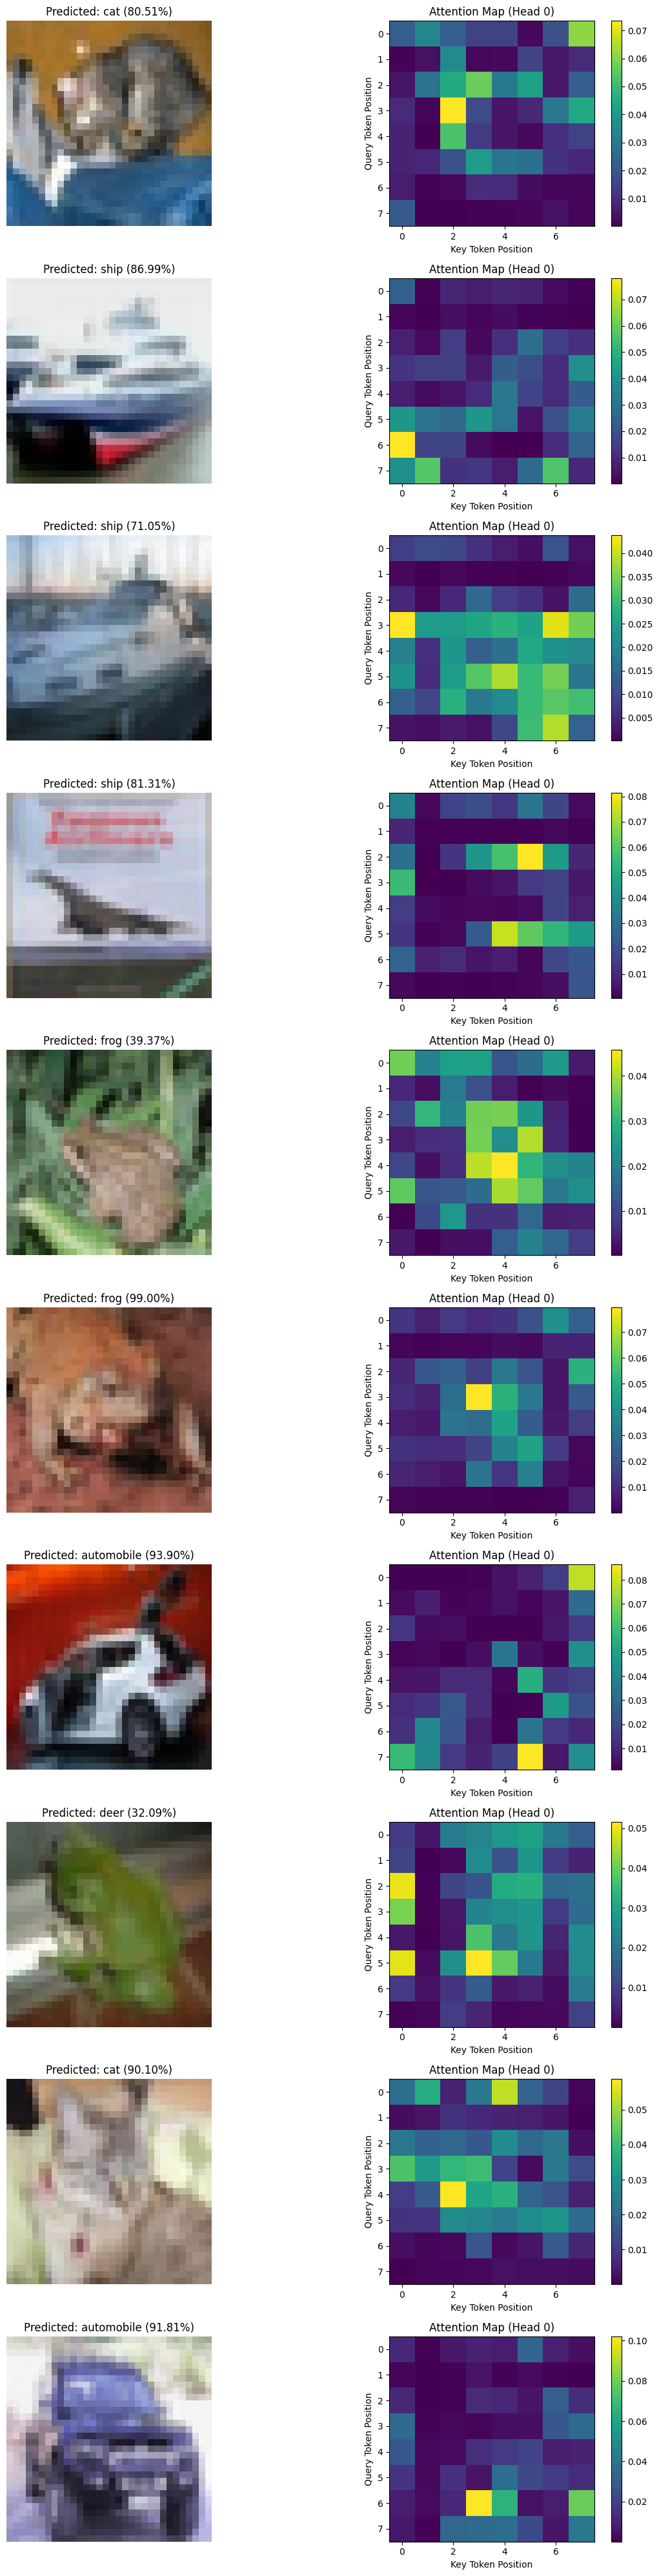

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assume model is defined, compiled, and trained to output [predictions, attention_scores].
# Also assume x_test is loaded and normalized.

# Class names for CIFAR-10 (modify if using another dataset)
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# Choose how many images to visualize
num_images =10
sample_imgs = x_test[:num_images]  # shape: (num_images, 32, 32, 3)

# Obtain predictions and attention scores
# preds: shape (num_images, num_classes)
# attn: shape (num_images, num_heads, seq_length, seq_length)
preds, attn = model.predict(sample_imgs)

# Create a figure: 2 columns (image & attention map), num_images rows
fig, axes = plt.subplots(num_images, 2, figsize=(12, 4 * num_images))

for i in range(num_images):
    # Show the original image
    axes[i, 0].imshow(sample_imgs[i])
    axes[i, 0].axis("off")

    # Prediction info
    pred_class = np.argmax(preds[i])
    pred_prob = np.max(preds[i])
    axes[i, 0].set_title(f"Predicted: {class_names[pred_class]} ({pred_prob*100:.2f}%)")

    # Extract attention map for the first head
    head_index = 0
    attn_map = attn[i, head_index]  # shape: (64, 64)

    # Reshape the 64×64 map into (8, 8, 8, 8) then average to get an 8×8 map
    attn_map_reshaped = attn_map.reshape(8, 8, 8, 8)
    attn_map_avg = attn_map_reshaped.mean(axis=(0, 1))

    # Display the averaged 8×8 attention map
    im = axes[i, 1].imshow(attn_map_avg, cmap='viridis')
    axes[i, 1].set_title(f"Attention Map (Head {head_index})")
    axes[i, 1].set_xlabel("Key Token Position")
    axes[i, 1].set_ylabel("Query Token Position")

    # Optional: add a colorbar to each attention map
    fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# Interpretation Notes:
# 1. Each image is split into 64 patches (an 8×8 grid). The raw attention map
#    is 64×64, indicating how each patch (query) relates to every other patch (key).
# 2. By reshaping to (8, 8, 8, 8) and averaging, we obtain an 8×8 heatmap that
#    visually corresponds to the 8×8 spatial layout of patches in the original image.
# 3. Brighter areas (higher values) mean a patch is placing stronger attention
#    on another patch, highlighting important regions or relationships the model
#    relies on for classification.




---



---



---



---



Exercice 2 ViT : Building the Vision Transformer (ViT) Model

In this Second excercice, you will construct a Vision Transformer (ViT) model for classifying images. Unlike a typical CNN or even a hybrid CNN-attention model, the ViT model processes the image by first splitting it into small patches. Each patch is then projected into an embedding space, forming a sequence of tokens. This sequence is fed into multiple Transformer blocks, where each block consists of multi-head self-attention layers followed by a feed-forward network, both employing residual connections and layer normalization. Finally, a global average pooling aggregates the sequence, and a multi-layer perceptron (MLP) performs the classification.

Key differences compared to the previous CNN-attention model:

-Patch Extraction:
The ViT model divides the input image into fixed-size patches (e.g., 4×4) using a convolutional layer, then flattens these patches into a sequence of embeddings. In contrast, the CNN-attention model used several convolutional layers to extract local features before applying attention.

-Transformer Processing:
The ViT directly processes the sequence of patch embeddings with Transformer blocks, capturing global relationships between patches from the start. In the CNN-attention model, attention was applied on features extracted by several convolutional layers.

-Aggregation and Classification:
Both models use a form of pooling (global average pooling) before the final classification MLP, but the ViT’s approach emphasizes learning global dependencies right from the patch level.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Hyperparameters
input_shape = (32, 32, 3)
num_classes = 10
patch_size = 4      # Patch size (4x4)
embed_dim = 64      # Embedding dimension for patches
num_heads = 4       # Number of attention heads
ff_dim = 128        # Feed-forward network dimension
num_transformer_blocks = 4
dropout_rate = 0.1

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

# Function to extract patches from the image
def extract_patches(inputs, patch_size):
    patches = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    patches = layers.Reshape((-1, embed_dim))(patches)  # (num_patches, embed_dim)
    return patches

# Transformer Block
def transformer_block(inputs):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([x, inputs])  # Residual connection

    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(ff_dim, activation="relu")(y)
    y = layers.Dense(embed_dim)(y)
    y = layers.Dropout(dropout_rate)(y)
    return layers.Add()([x, y])  # Residual connection

# Build the ViT model
inputs = layers.Input(shape=input_shape)
x = extract_patches(inputs, patch_size)

# Add Transformer Blocks
for _ in range(num_transformer_blocks):
    x = transformer_block(x)

# Pooling and Classification
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

# Training
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

# Evaluation
model.evaluate(x_test, y_test)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 151s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 8, 8, 64)       │          3,136 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 64)         │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 64)         │            128 │ reshape[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 64, 64)         │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64)         │              0 │ multi_head_attention[… │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64, 128)        │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64, 64)         │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64)         │              0 │ add[0][0],             │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 64, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 64, 64)         │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 64, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 340,746 (1.30 MB)

 Trainable params: 340,746 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - accuracy: 0.1446 - loss: 2.2475 - val_accuracy: 0.2844 - val_loss: 1.8206
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.2734 - loss: 1.8606 - val_accuracy: 0.3235 - val_loss: 1.7784
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.3292 - loss: 1.7624 - val_accuracy: 0.3637 - val_loss: 1.6971
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.3544 - loss: 1.7076 - val_accuracy: 0.3970 - val_loss: 1.6214
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.3819 - loss: 1.6510 - val_accuracy: 0.4036 - val_loss: 1.6178
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.4161 - loss: 1.6003 - val_accuracy: 0.4419 - val_loss: 1.5198
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4296 - loss: 1.5548 - val_accuracy: 0.4635 - val_loss: 1.4762
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4555 - loss: 1.5017 - 

[1.399152159690857, 0.49129998683929443]

**Q 1**: Describe the Overall Architecture

The model accepts an input image of size (32, 32, 3). It uses a convolutional layer with a kernel size equal to the patch size (4×4) to split the image into non-overlapping patches. Each patch is projected into an embedding space (dimension 64) and flattened into a sequence of tokens. This sequence is then fed into 4 Transformer blocks where each block applies layer normalization, multi-head self-attention (with 4 heads), and a feed-forward network. Residual connections are added after both the attention and feed-forward sub-layers. Finally, Global Average Pooling aggregates the sequence into a single feature vector, which is passed through a small MLP (Dense layers with dropout) to classify the image into one of 10 classes.




---



---



---



**Q2**
Analyze the function extract_patches and explain in detail how it divides the image into patches and converts them into a sequence of embeddings.

The function extract_patches uses a convolutional layer with a kernel size of 4 and strides of 4, effectively splitting the image into non-overlapping 4×4 patches. Each patch is projected to an embedding vector of dimension 64. The output of the convolution has a shape corresponding to (patch_height, patch_width, embed_dim). The subsequent Reshape layer flattens these spatial dimensions into one, converting the tensor into a sequence of shape (num_patches, embed_dim).

**Q3**
Break down the transformer_block function and explain each step.





---



---


---



First, the block applies layer normalization to standardize the inputs, which stabilizes the training. Then, the MultiHeadAttention layer computes self-attention by using the normalized input as queries, keys, and values. A residual connection is added by summing the attention output with the original input, preserving the original information. Next, the block normalizes the result again before passing it through a feed-forward network: the first Dense layer with ff_dim units and ReLU activation increases the model's capacity to learn complex representations, and the second Dense layer projects the features back to the original embedding dimension. A dropout is applied for regularization, and finally, a second residual connection is added by summing the feed-forward output with its input.

**Q4**  Describe the final stages of the model after the Transformer blocks. Explain the role of GlobalAveragePooling1D and how the MLP performs the classification.

GlobalAveragePooling1D computes the average of each feature across all tokens, producing a single vector that summarizes the entire image. This vector is then fed into a Dense layer with 64 units and ReLU activation, which learns a non-linear combination of the features. A dropout layer with a rate of 0.2 is applied to reduce overfitting. Finally, the output layer uses softmax activation to generate a probability distribution over the 10 CIFAR-10 classes.



---



---



---



**Q5**
Analyse the block "extract_patches", compute the total number of parameters and compute input and output dimension

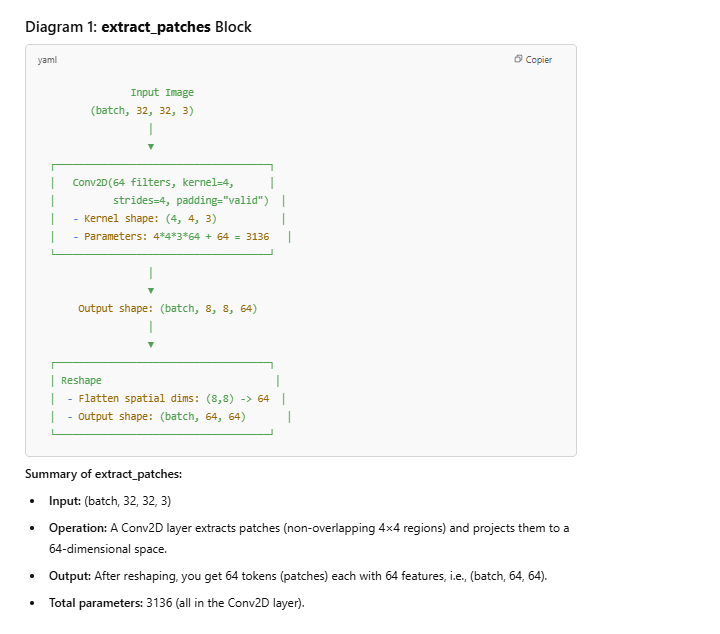

Therefore, the extract_patches function takes an image of shape (32,32,3), produces a sequence of 64 patch embeddings (each of dimension 64), and uses 3136 parameters in its convolutional layer:


embed_dim = 64: This is the number of filters in the Conv2D.
patch_size = 4: The convolution kernel size (4×4) and stride (4,4).

**Input to extract_patches:**
(batch_size, 32, 32, 3)
(Here, (32, 32, 3) is the spatial and channel dimension.)

**Convolution layer**
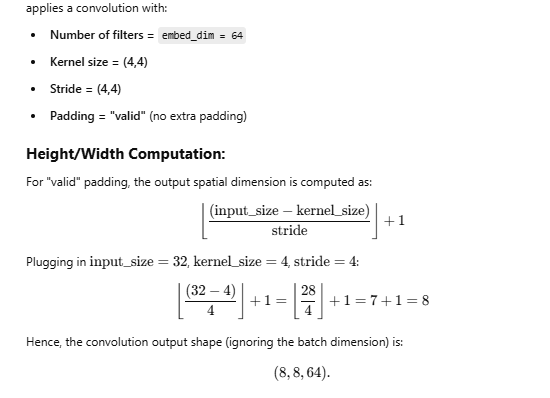

**Reshape Output Shape**


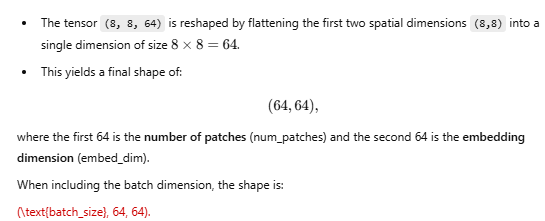


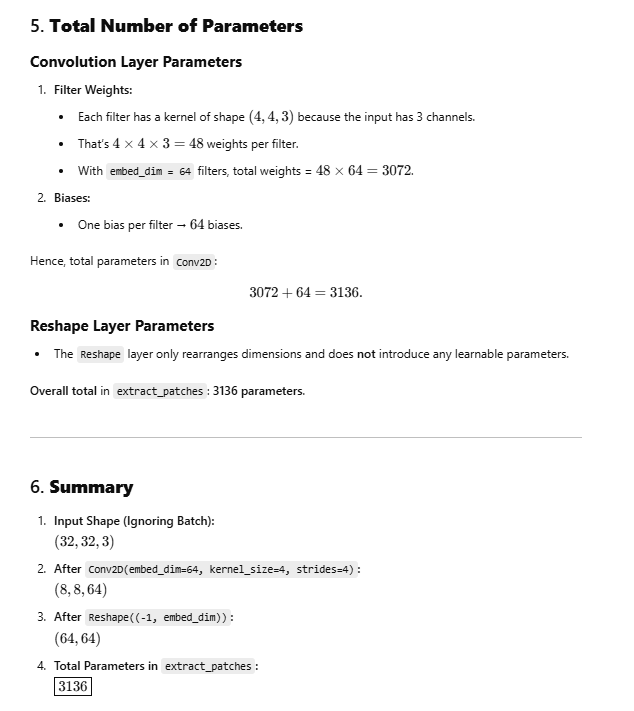



---



---



---



# Q6

What is the meaning of the layer?
 "    x = layers.LayerNormalization(epsilon=1e-6)(inputs),
why it is used?

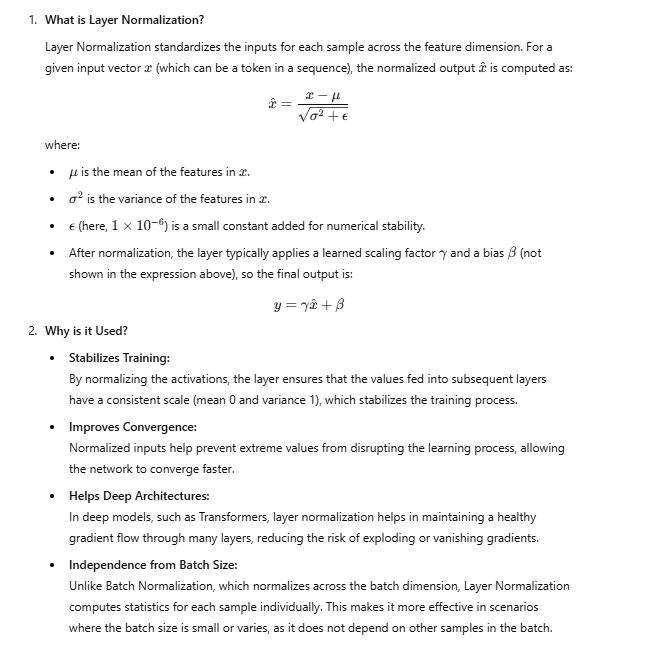



---



---



---



**Q7**
Analyse the block "transformer_block", compute the total number of parameters and compute input and output dimension

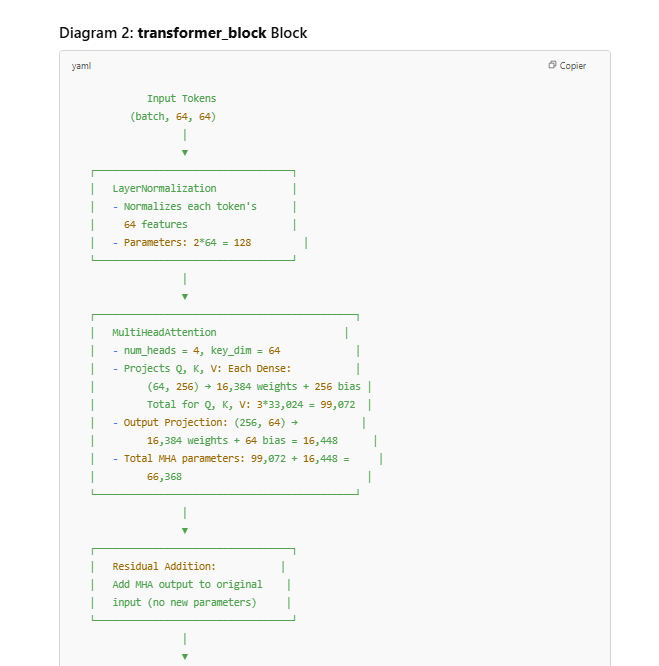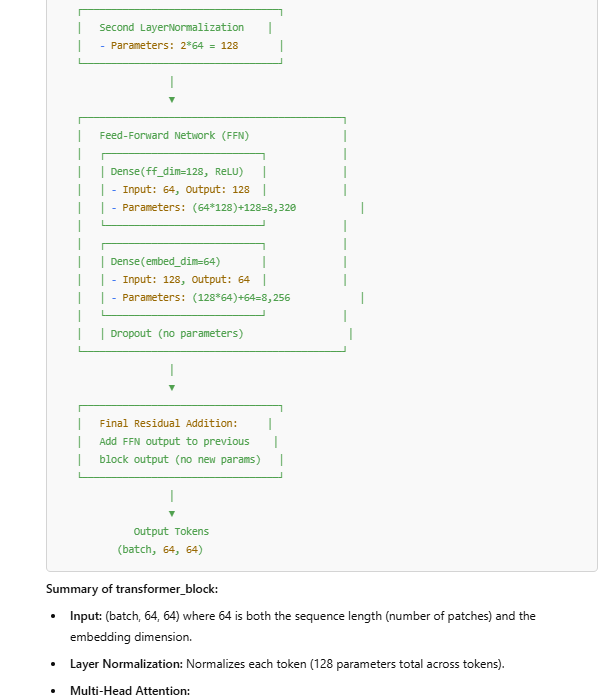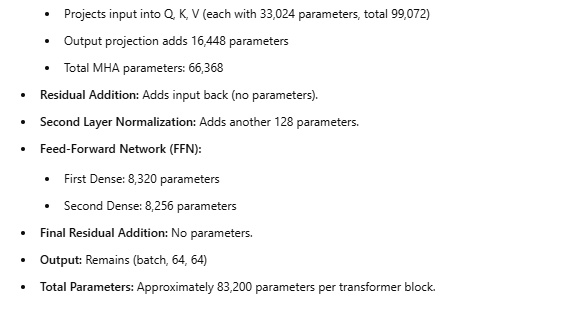

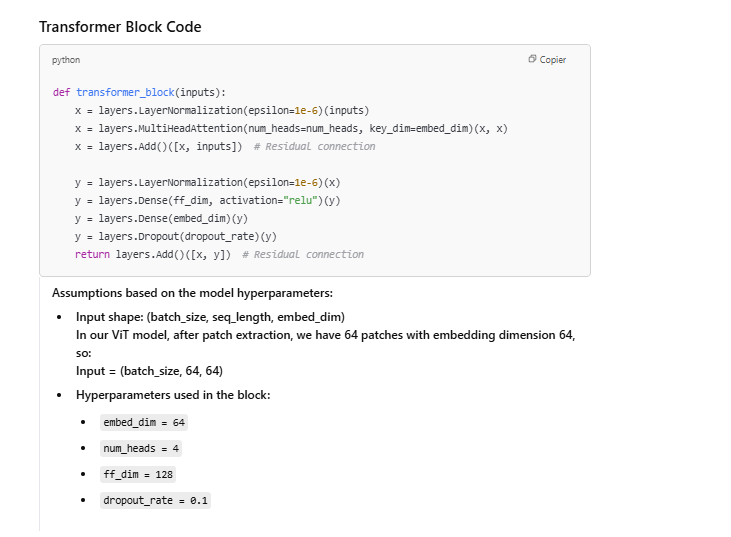


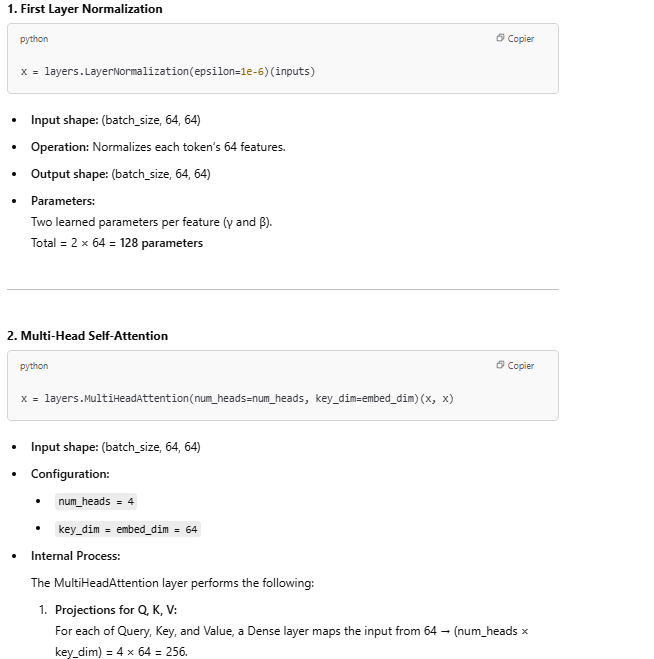

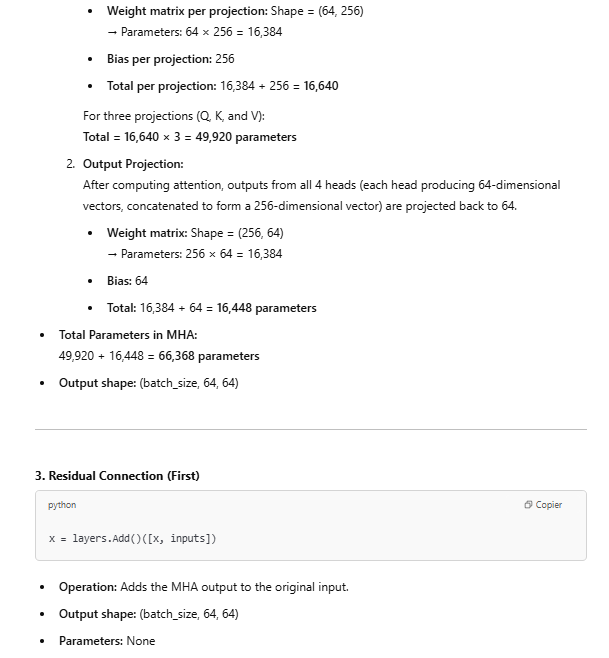

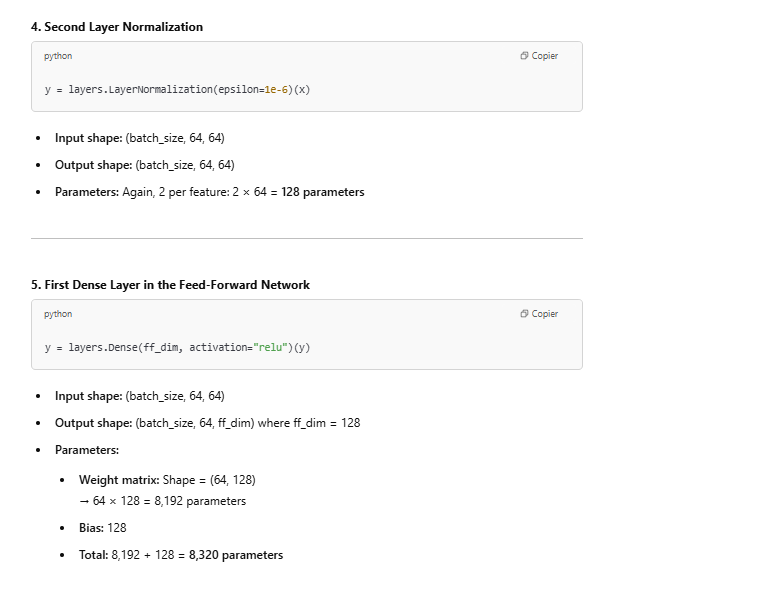

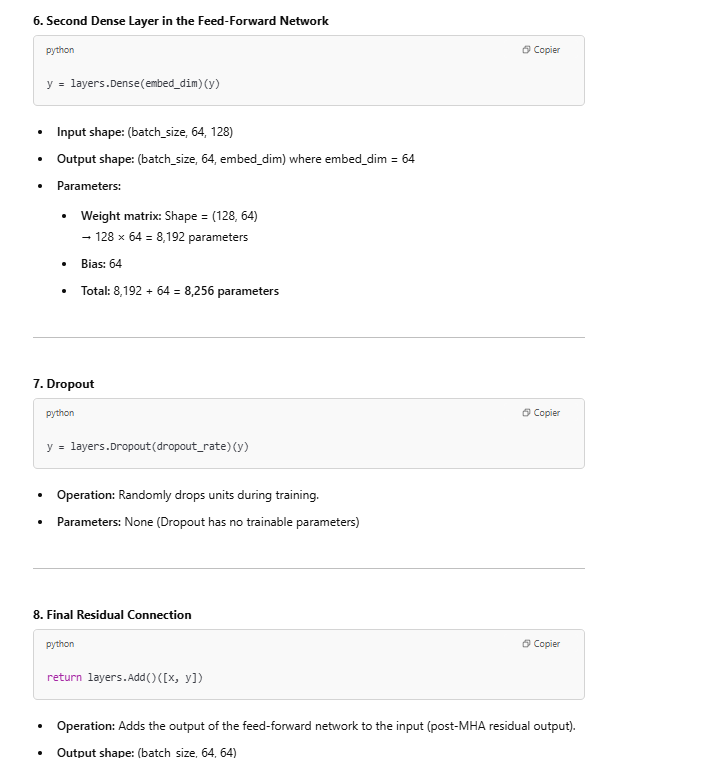

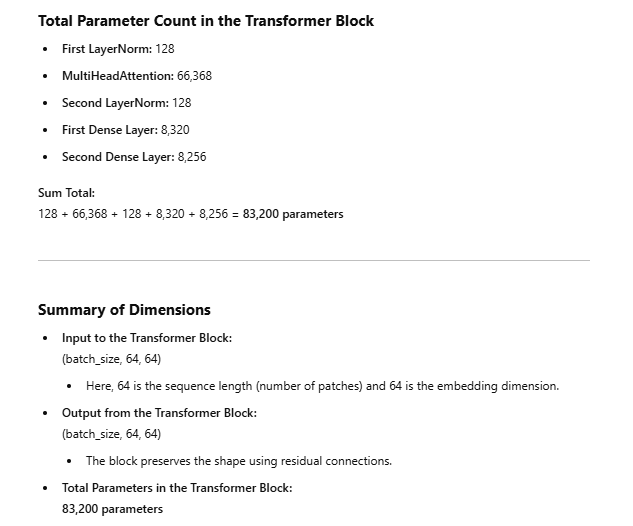

# Q8
Explain whats happend during  the layer *MultiHeadAttention*

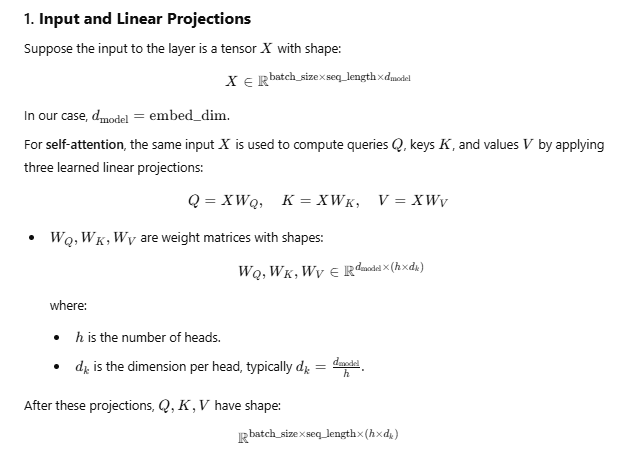
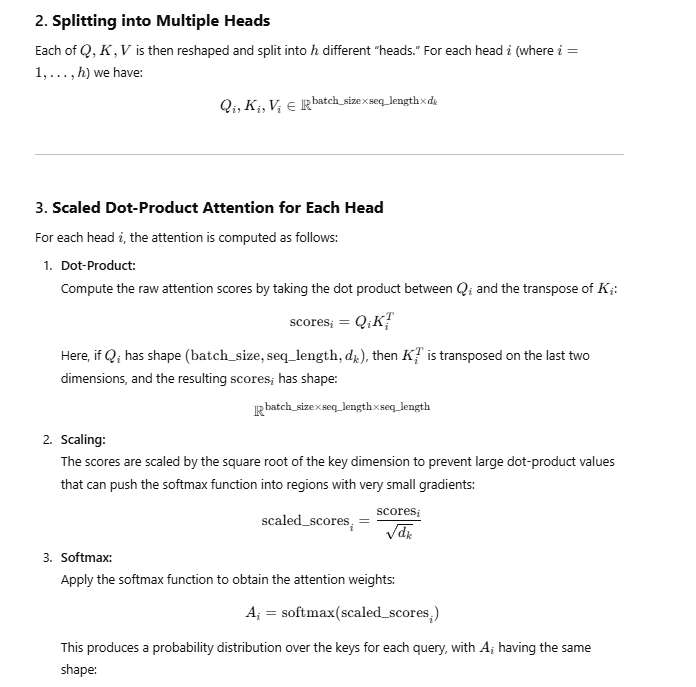
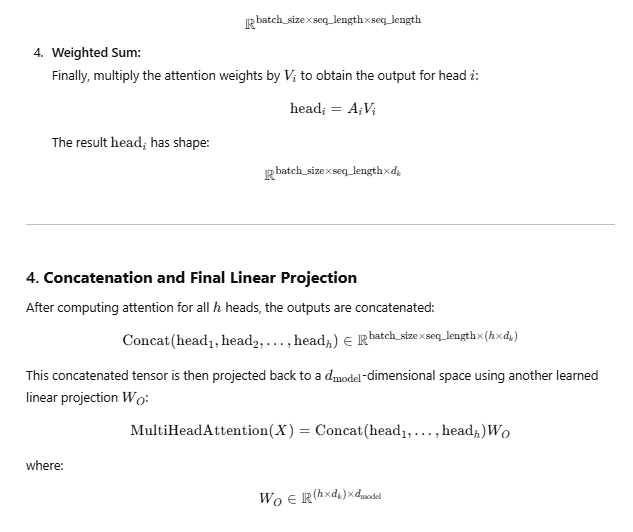
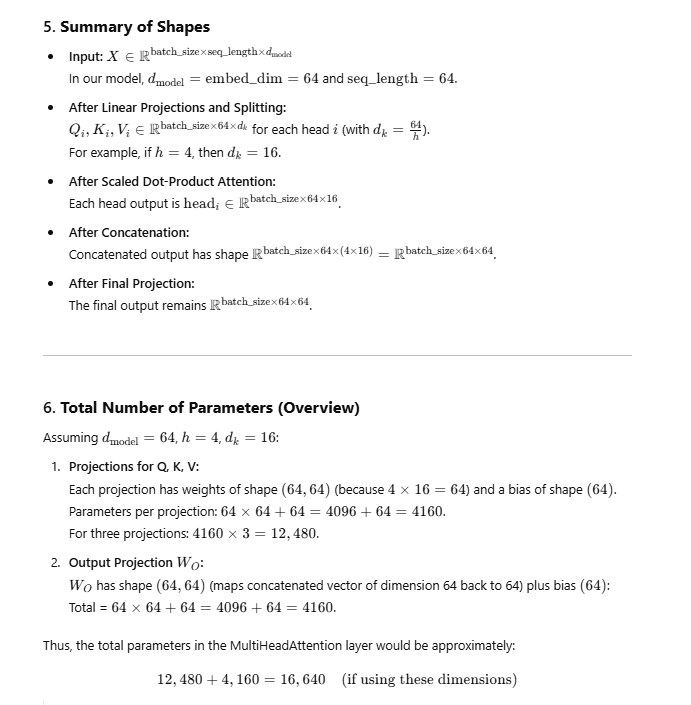
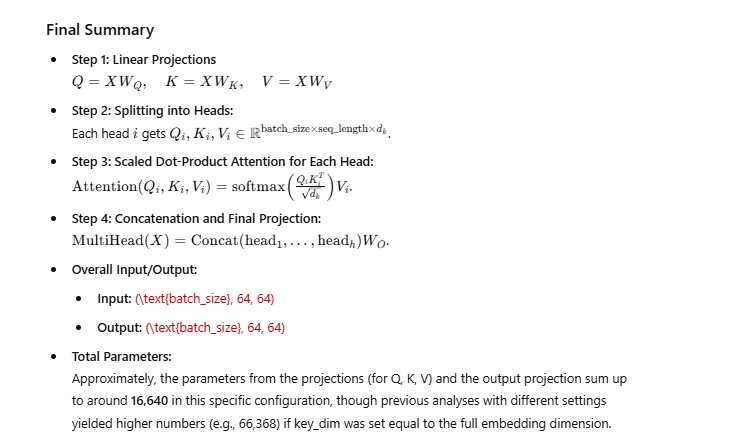



---



---



---



---



# Q9
What are the key differences compared to the previous CNN-attention model:




**Patch Extraction:**
The ViT model divides the input image into fixed-size patches (e.g., 4×4) using a convolutional layer, then flattens these patches into a sequence of embeddings. In contrast, the CNN-attention model used several convolutional layers to extract local features before applying attention.

**Transformer Processing:**
The ViT directly processes the sequence of patch embeddings with Transformer blocks, capturing global relationships between patches from the start. In the CNN-attention model, attention was applied on features extracted by several convolutional layers.

**Aggregation and Classification:**
Both models use a form of pooling (global average pooling) before the final classification MLP, but the ViT’s approach emphasizes learning global dependencies right from the patch level.




---



---



---



**Q10**

Propose a transfer learning approach on the CIFAR-10 dataset using a pretrained Vision Transformer (ViT) from the Hugging Face Transformers library.

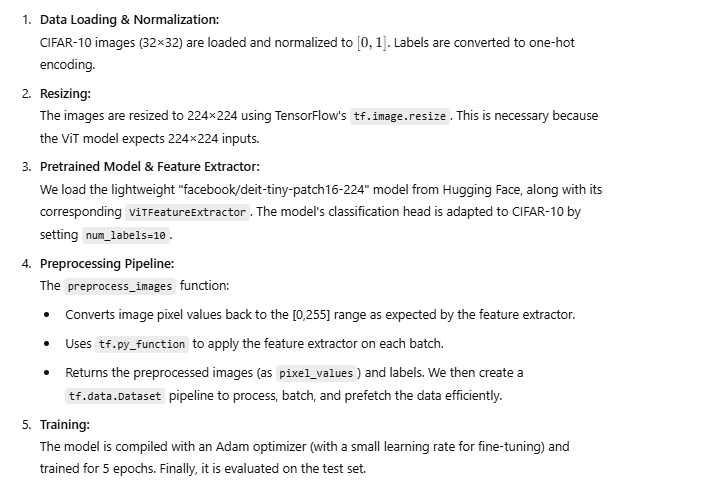

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from transformers import TFViTForImageClassification, ViTFeatureExtractor
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# ---------------------------
# Hyperparameters
# ---------------------------
IMG_SIZE = 224       # ViT expects 224x224 images
BATCH_SIZE = 32
NUM_CLASSES = 10
MODEL_NAME = "facebook/deit-tiny-patch16-224"  # A lightweight ViT model

# ---------------------------
# Load CIFAR-10 Data
# ---------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize images to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Convert labels to one-hot vectors
y_train = to_categorical(y_train, NUM_CLASSES)
y_test  = to_categorical(y_test, NUM_CLASSES)

# ---------------------------
# Resize Images to 224x224
# ---------------------------
# (We use tf.image.resize on the fly using a tf.data.Dataset pipeline)
x_train_resized = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE))
x_test_resized  = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE))

# ---------------------------
# Load Pretrained Model and Feature Extractor
# ---------------------------
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)
model = TFViTForImageClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)

# Optionally, you can freeze the base model layers if needed:
# model.deit.trainable = False

# ---------------------------
# Preprocessing Function
# ---------------------------
def preprocess_images(images, labels):
    # Convert images from [0,1] float to uint8 [0,255]
    images = tf.cast(images * 255, tf.uint8)
    # Use tf.py_function to apply the feature extractor on a batch of images.
    def process_batch(imgs):
        # imgs: numpy array of shape (batch_size, IMG_SIZE, IMG_SIZE, 3)
        encoded = feature_extractor(images=list(imgs), return_tensors="tf")
        return encoded["pixel_values"]
    pixel_values = tf.py_function(process_batch, [images], tf.float32)
    # Set the expected shape (None for batch dimension)
    pixel_values.set_shape((None, IMG_SIZE, IMG_SIZE, 3))
    return pixel_values, labels

# ---------------------------
# Create tf.data.Dataset Pipelines
# ---------------------------
train_ds = tf.data.Dataset.from_tensor_slices((x_train_resized, y_train))
train_ds = train_ds.map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test_resized, y_test))
test_ds = test_ds.map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ---------------------------
# Compile and Fine-Tune the Model
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(train_ds, epochs=5, validation_data=test_ds)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
